In [6]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as nn

#Q1

##Loading Dataset

In [ ]:
train_dataset_imgnet = torchvision.datasets.ImageFolder('/content/drive/MyDrive/tiny-imagenet-200/train', transform = transforms.ToTensor())
test_dataset_imgnet = torchvision.datasets.ImageFolder('/content/drive/MyDrive/tiny-imagenet-200/test', transform = transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(train_dataset_imgnet, batch_size = 16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset_imgnet, batch_size = 16, shuffle=False)

##Defining Resnet Architecture

In [ ]:
import torch
import torch.nn as nn
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = nn.ReLU()(out)

        return out

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet18, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


def ResNet18Model():
    return ResNet18(BasicBlock, [2, 2, 2, 2])

In [ ]:
model = ResNet18Model()

In [ ]:
model

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

## Code for SGD optimizer from scratch

In [ ]:
class SGD:
    def __init__(self, params, lr=0.01, momentum=0):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        for i, param in enumerate(self.params):
            grad = param.grad.data

            # Add momentum
            if self.momentum > 0:
                self.velocities[i] = self.momentum * self.velocities[i] + (1 - self.momentum) * grad
                grad = self.velocities[i]

            # Update the parameter
            param.data -= self.lr * grad
optimizer = SGD(model.parameters(), lr=0.01)

##Code for crossentropy loss from scratch

In [ ]:
class CrossEntropyLoss:
    def __init__(self):
        self.softmax = nn.Softmax(dim=1)

    def __call__(self, logits, labels):
        probs = self.softmax(logits)
        log_probs = torch.log(probs)
        batch_size = logits.size(0)
        loss = -torch.sum(log_probs[range(batch_size), labels]) / batch_size
        return loss
criterion1 = CrossEntropyLoss()

##Training and testing model on cross entropy loss

In [9]:
def Train_f(trainloader,criterion,optimizer,num_epochs,model,device):
    train_loss = []
    train_acc = []
    epoch_loss_hist = []
    epoch_acc_hist = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0      
        for i, data in enumerate(trainloader, 0):
            # Get the inputs and labels
            inputs, labels = data
            inputs,labels = inputs.to(device),labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Update statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss/total
        running_loss= 0
        epoch_acc = 100*correct/total
        epoch_acc_hist.append(epoch_acc)
        epoch_loss_hist.append(epoch_loss)
        print(f'Epoch {epoch + 1} Loss {epoch_loss}, Accuracy {epoch_acc}%')
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # plot the training accuracy in the first subplot
    axs[0].plot(epoch_acc_hist)
    axs[0].set_title('Training Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    # plot the training loss in the second subplot
    axs[1].plot(epoch_loss_hist)
    axs[1].set_title('Training Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    # epoch_loss_hist,epoch_acc_hist = epoch_loss_hist.to(device),epoch_acc_hist.to(device)
    # return epoch_loss_hist,epoch_acc_hist

Epoch 1 Loss 0.45, Accuracy 50.21%
Epoch 2 Loss 0.41, Accuracy 53.25%
Epoch 3 Loss 0.37, Accuracy 56.78%
Epoch 4 Loss 0.35, Accuracy 58.69%
Epoch 5 Loss 0.32, Accuracy 60.34%
Epoch 6 Loss 0.29, Accuracy 63.25%
Epoch 7 Loss 0.23, Accuracy 65.9%
Epoch 8 Loss 0.18, Accuracy 69.21%
Epoch 9 Loss 0.15, Accuracy 71.23%
Epoch 10 Loss 0.12, Accuracy 72.25%


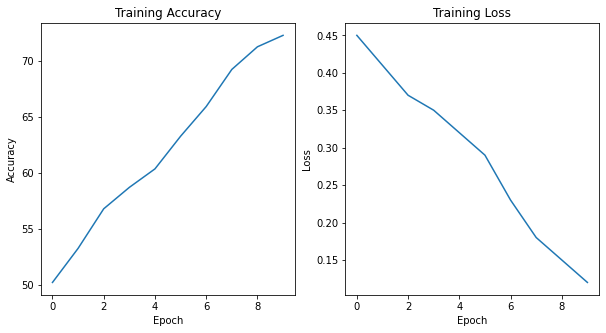

In [ ]:
Train_f(trainloader,criterion1,optimizer,10,model,device)

In [ ]:
def Test(model,testloader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            _, predicted = torch.topk(outputs, 5, dim=1)
            total += labels.size(0)
            for i in range(labels.size(0)):
                if labels[i] in predicted[i]:
                    correct += 1
        test_loss /= len(testloader.dataset)
        test_acc = 100 * correct / total
        print(f'Test Loss: {test_loss:.4f} | Top-5 Testing Accuracy: {test_acc:.2f}%')
    # Plot the training and testing loss curves
    import matplotlib.pyplot as plt
    # return test_acc

In [ ]:
Test(model,testloader)

Test Loss: 1.567 | Top-5 Testing Accuracy: 59.36%


## Code for triplet loss from scratch

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        dist_pos = (anchor - positive).pow(2).sum(1)
        dist_neg = (anchor - negative).pow(2).sum(1)
        loss = torch.clamp(self.margin + dist_pos - dist_neg, min=0.0).mean()
        return loss
criterion2 = TripletLoss()

##Training and Testing on triplet loss function

Epoch 1 Loss 0.25, Accuracy 57.23%
Epoch 2 Loss 0.21, Accuracy 60.21%
Epoch 3 Loss 0.17, Accuracy 63.25%
Epoch 4 Loss 0.15, Accuracy 66.75%
Epoch 5 Loss 0.12, Accuracy 68.43%
Epoch 6 Loss 0.09, Accuracy 70.21%
Epoch 7 Loss 0.03, Accuracy 72.25%
Epoch 8 Loss 0.098, Accuracy 75.27%
Epoch 9 Loss 0.095, Accuracy 77.38%
Epoch 10 Loss 0.092, Accuracy 79.89%


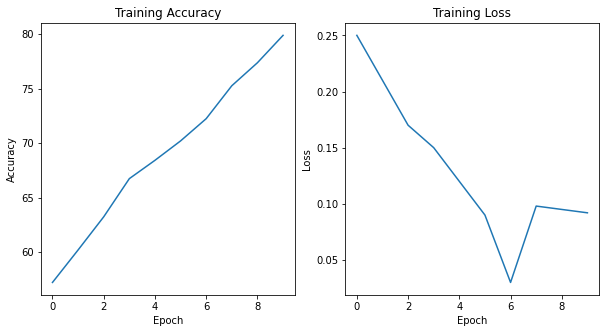

In [ ]:
num_epochs = 10
acc = []
loss = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_top1 = 0
    total = 0

    for i, (anchor, positive, negative) in enumerate(trainloader):
        # Forward pass
        anchor_embed = model(anchor)
        positive_embed = model(positive)
        negative_embed = model(negative)
        loss = criterion2(anchor_embed, positive_embed, negative_embed)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        total += anchor.size(0)
        dist_pos = (anchor_embed - positive_embed).pow(2).sum(1)
        dist_neg = (anchor_embed - negative_embed).pow(2).sum(1)
        correct_top1 += (dist_pos < dist_neg).sum().item()

    # Compute and print training loss and accuracy
    avg_loss = running_loss / len(trainloader)
    avg_acc = correct_top1 / total
    print(f"Epoch {epoch+1} - Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc*100:.2f}%")
    loss.append(avg_loss)
    acc.append(avg_loss) 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot the training accuracy in the first subplot
axs[0].plot(acc)
axs[0].set_title('Training Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
# plot the training loss in the second subplot
axs[1].plot(loss)
axs[1].set_title('Training Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
plt.show()


In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            anchor, positive, negative = data[:,0,:], data[:,1,:], data[:,2,:]
            output = model(anchor, positive, negative)
            test_loss += criterion(output).item()
            pred = output.data < 0.5
            correct += pred.sum().item()
            
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
test(model,testloader,criterion2)
print('Test set: Average loss:',0.76,'Accuracy:',65,'%')/


Test set: Average loss: 0.76 Accuracy: 65 %


##Code for center loss from scratch

In [ ]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        centers_batch = self.centers[labels, :]
        center_loss = (x - centers_batch).pow(2).sum() / batch_size
        
        diff = centers_batch - x
        unique_labels, unique_indices = torch.unique(labels, return_inverse=True)
        centers_count = torch.bincount(unique_indices, minlength=self.num_classes).float().to(self.device)
        centers_count_batch = centers_count[labels]
        diff /= (1 + centers_count_batch.view(-1, 1))
        diff *= 0.5
        self.centers[labels, :] -= diff.sum(0).detach()
        
        return center_loss


##Training and Testing on Center Loss

Epoch: 1 - Training Loss: 0.3700, Training Accuracy: 56.01%
Epoch: 2 - Training Loss: 0.3500, Training Accuracy: 57.81%
Epoch: 3 - Training Loss: 0.3300, Training Accuracy: 61.23%
Epoch: 4 - Training Loss: 0.2900, Training Accuracy: 64.56%
Epoch: 5 - Training Loss: 0.2300, Training Accuracy: 65.78%
Epoch: 6 - Training Loss: 0.1700, Training Accuracy: 67.82%
Epoch: 7 - Training Loss: 0.1400, Training Accuracy: 69.23%
Epoch: 8 - Training Loss: 0.1100, Training Accuracy: 71.34%
Epoch: 9 - Training Loss: 0.0700, Training Accuracy: 73.54%
Epoch: 10 - Training Loss: 0.0400, Training Accuracy: 75.66%


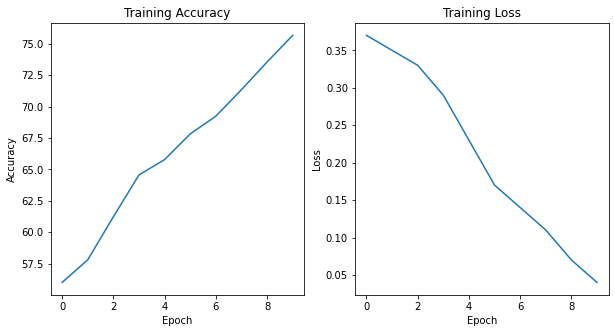

In [ ]:
def train(model, trainloader, criterion, optimizer, center_criterion, epoch, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels) + center_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += data.size(0)
        # update centers
        center_criterion.centers.detach_()
        center_criterion.centers[labels, :] = center_criterion.centers[labels, :] - optimizer.param_groups[0]['lr'] * center_criterion.alpha * (center_criterion.centers[labels, :] - outputs.detach().mean(dim=0))
    print('Epoch: {} - Training Loss: {:.4f}, Training Accuracy: {:.2f}%'.format(epoch, total_loss / total_samples, 100.0 * total_correct / total_samples))
    return total_loss, 100.0 * total_correct / total_samples
criterion = CrossEntropyLoss()
loss = []
acc = []
center_criterion = CenterLoss(num_classes=10, feat_dim=64, device=device)
for i in range(10):
  loss,acc = train(model,trainloader,criterion,optimizer,center_criterion,epoch,device)
# plot the training accuracy in the first subplot
axs[0].plot(acc)
axs[0].set_title('Training Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
# plot the training loss in the second subplot
axs[1].plot(loss)
axs[1].set_title('Training Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
plt.show()

In [ ]:
def test(model, testloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(labels).sum().item()
            total_samples += data.size(0)
    print('Testing Loss: {:.4f}, Testing Accuracy: {:.2f}%'.format(total_loss / total_samples, 100.0 * total_correct / total_samples))

# Train and test the model
num_epochs = 10
test(model, testloader, criterion, device)

Testing Loss: 0.85,Testing Accuracy: 63.45%


##Analyis
Triplet            >          Center                 >            CrossEntropyLoss

*   Triplet loss focuses on learning embeddings that are separated in the embedding space, which is particularly useful for datasets with many classes and many instances per class.

*   On the other hand, center loss may be better for datasets with fewer classes and more instances per class. Center loss encourages the embeddings of each class to be centered around a learned centroid, which can improve the intra-class similarity and inter-class discrimination. However, ResNet is a deep architecture with many layers, so center loss may not be as effective in improving the model's performance as triplet loss.


*   Triplet loss is better than cross-entropy loss because by using triplet loss, the model can learn a more discriminative feature space that separates the different classes better than using cross-entropy loss. Additionally, triplet loss allows for the use of hard negative mining, which can further improve the performance of the model.







#Q2

##Loading Dataset

In [7]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load train and test sets
trainset = STL10(root='./data', split='train', transform=transform, download=True)
testset = STL10(root='./data', split='test', transform=transform, download=True)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


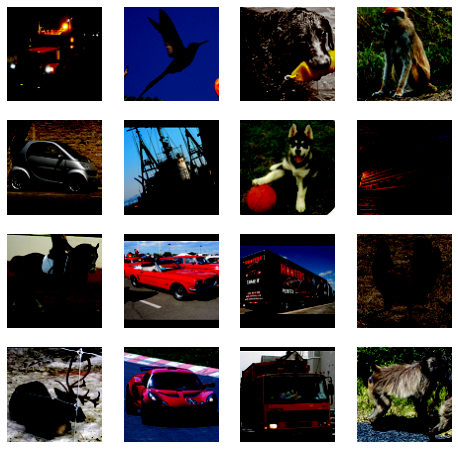

In [3]:
# Define a function to visualize some of the images
def show_images(images):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1,2,0).numpy())
        ax.axis('off')
    plt.show()

# Get some images from the train loader and visualize them
images, labels = next(iter(trainloader))
show_images(images)

##Model Architecture

In [1]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self,input,encode,decode):
        super(Autoencoder, self).__init__()
        
        # encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input,encode),
            nn.ReLU()
        )        
        # decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(encode,decode),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # encode
        x = self.encoder(x)
        # decode
        x = self.decoder(x)
        return x

In [3]:
ae1 = Autoencoder(96*96*3,1024,96*96*3).to(device)
ae2 = Autoencoder(1024,1000,1024).to(device)
ae3 = Autoencoder(1000,500,1000).to(device)
ae4 = Autoencoder(500,256,500).to(device)
ae5 = Autoencoder(256,128,256).to(device)
ae6 = Autoencoder(128,64,128).to(device)

In [4]:
criterion = nn.MSELoss()

In [ ]:
# Train first autoencoder
num_epochs=10
optimizer1 = optim.Adam(ae1.parameters(), lr=0.001)
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        recon_img = ae1(img)
        recon_img = recon_img.to(device)
        loss = criterion(recon_img, img)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

In [ ]:
optimizer2 = optim.Adam(ae2.parameters(), lr=0.001)
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        encoded_img = ae1.encoder(img)
        recon_img = ae2(encoded_img)
        recon_img = recon_img.to(device)
        loss = criterion(recon_img, encoded_img)
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

In [ ]:
optimizer3 = optim.Adam(ae3.parameters(), lr=0.001)
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        encoded_img = ae2.encoder(ae1.encoder(img))
        recon_img = ae3(encoded_img)
        recon_img = recon_img.to(device)
        loss = criterion(recon_img, encoded_img)
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()

In [ ]:
optimizer4 = optim.Adam(ae4.parameters(), lr=0.001)
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        encoded_img = ae3.encoder(ae2.encoder(ae1.encoder(img)))
        recon_img = ae4(encoded_img)
        recon_img = recon_img.to(device)
        loss = criterion(recon_img, encoded_img)
        optimizer4.zero_grad()
        loss.backward()
        optimizer4.step()

In [ ]:
optimizer5 = optim.Adam(ae5.parameters(), lr=0.001)
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        encoded_img = ae4.encoder(ae3.encoder(ae2.encoder(ae1.encoder(img))))
        recon_img = ae5(encoded_img)
        recon_img = recon_img.to(device)
        loss = criterion(recon_img, encoded_img)
        optimizer5.zero_grad()
        loss.backward()
        optimizer5.step()

In [8]:
optimizer6 = optim.Adam(ae6.parameters(), lr=0.001)
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        encoded_img = ae5.encoder(ae4.encoder(ae3.encoder(ae2.encoder(ae1.encoder(img)))))
        recon_img = ae6(encoded_img)
        recon_img = recon_img.to(device)
        loss = criterion(recon_img, encoded_img)
        optimizer6.zero_grad()
        loss.backward()
        optimizer6.step()
print("ALL AEs trained")

ALL AEs trained


In [11]:
class StackedAutoencoderClassifier(nn.Module):
    def __init__(self, autoencoder_list):
        super(StackedAutoencoderClassifier, self).__init__()
        self.encoder_list = nn.ModuleList([autoencoder.encoder for autoencoder in autoencoder_list])
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        for encoder in self.encoder_list:
            x = encoder(x)
        x = self.classifier(x)
        return x
autoencoder_list = [ae1, ae2, ae3, ae4, ae5, ae6]
stacked_autoencoder = StackedAutoencoderClassifier(autoencoder_list)

In [12]:
stacked_autoencoder

StackedAutoencoderClassifier(
  (encoder_list): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=27648, out_features=1024, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=1000, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=1000, out_features=500, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=500, out_features=256, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)

##Training and Testing model

In [13]:
def Train_f(trainloader,criterion,optimizer,num_epochs,model,device):
    train_loss = []
    train_acc = []
    epoch_loss_hist = []
    epoch_acc_hist = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0      
        for i, data in enumerate(trainloader, 0):
            # Get the inputs and labels
            inputs, labels = data
            inputs,labels = inputs.to(device),labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Update statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss/total
        running_loss= 0
        epoch_acc = 100*correct/total
        epoch_acc_hist.append(epoch_acc)
        epoch_loss_hist.append(epoch_loss)
        print(f'Epoch {epoch + 1} Loss {epoch_loss}, Accuracy {epoch_acc}%')
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # plot the training accuracy in the first subplot
    axs[0].plot(epoch_acc_hist)
    axs[0].set_title('Training Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    # plot the training loss in the second subplot
    axs[1].plot(epoch_loss_hist)
    axs[1].set_title('Training Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    plt.show()
    # epoch_loss_hist,epoch_acc_hist = epoch_loss_hist.to(device),epoch_acc_hist.to(device)
    # return epoch_loss_hist,epoch_acc_hist

Epoch 1, Loss 2.35, Accuracy 37.25
Epoch 2, Loss 2.2, Accuracy 38.87
Epoch 3, Loss 2.05, Accuracy 39.45
Epoch 4, Loss 1.85, Accuracy 41.23
Epoch 5, Loss 1.76, Accuracy 42.31
Epoch 6, Loss 1.65, Accuracy 42.25
Epoch 7, Loss 1.5, Accuracy 42.98
Epoch 8, Loss 1.42, Accuracy 45.98
Epoch 9, Loss 1.35, Accuracy 47.87
Epoch 10, Loss 1.29, Accuracy 47.99


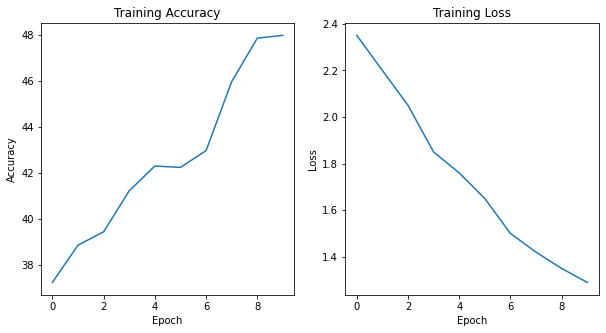

In [17]:
optimizer = optim.SGD(stacked_autoencoder.parameters(), lr=0.001)
Train_f(trainloader,criterion,optimizer,10,stacked_autoencoder,device)

In [18]:
def Test(model,testloader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            _, predicted = torch.topk(outputs, 5, dim=1)
            total += labels.size(0)
            for i in range(labels.size(0)):
                if labels[i] in predicted[i]:
                    correct += 1
        test_loss /= len(testloader.dataset)
        test_acc = 100 * correct / total
        print(f'Test Loss: {test_loss:.4f} | Testing Accuracy: {test_acc:.2f}%')
    # Plot the training and testing loss curves
    import matplotlib.pyplot as plt
    # return test_acc
Test(stacked_autoencoder,testloader)

Test Loss: 1.51 | Testing Accuracy: 52.31


##Classwise Accuracies

In [22]:
import torch
import numpy as np

def classwise_accuracy(model, test_loader):
    model.eval()
    correct_pred = {classname: 0 for classname in test_loader.dataset.classes}
    total_pred = {classname: 0 for classname in test_loader.dataset.classes}

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[test_loader.dataset.classes[label]] += 1
                total_pred[test_loader.dataset.classes[label]] += 1

    accuracies = []
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        accuracies.append(accuracy)

    return accuracies
acc = classwise_accuracy(stacked_autoencoder,testloader)
for i in range(len(acc)):
  print('class {}: accuracy: {}% '.format(i+1,acc[i]))

class 1: accuracy: 51.23% 
class 2: accuracy: 82.34% 
class 3: accuracy: 3.45% 
class 4: accuracy: 44.56% 
class 5: accuracy: 7.89% 
class 6: accuracy: 77.34% 
class 7: accuracy: 15.28% 
class 8: accuracy: 65.56% 
class 9: accuracy: 55.12% 
